<a href="https://colab.research.google.com/github/rebeccadimatteo/ExplainableAI/blob/main/DatasetConsumoAlcolStudentiLingua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**READING CSV FILES WITH DATASETS**


In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (40,20)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/ExplainableAI/master/datasetLingua.csv"

#fetch dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "datasetLingua.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/datasetLingua.csv")
df.head(2)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11


##**DATA CLEANING**

In [8]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [9]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

school        False
sex           False
age           False
address       False
famsize       False
Pstatus       False
Medu          False
Fedu          False
Mjob          False
Fjob          False
reason        False
guardian      False
traveltime    False
studytime     False
failures      False
schoolsup     False
famsup        False
paid          False
activities    False
nursery       False
higher        False
internet      False
romantic      False
famrel        False
freetime      False
goout         False
Dalc          False
Walc          False
health        False
absences      False
G1            False
G2            False
G3            False
dtype: bool

In [10]:
# statistiche descrittive di base per tutte le colonne
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


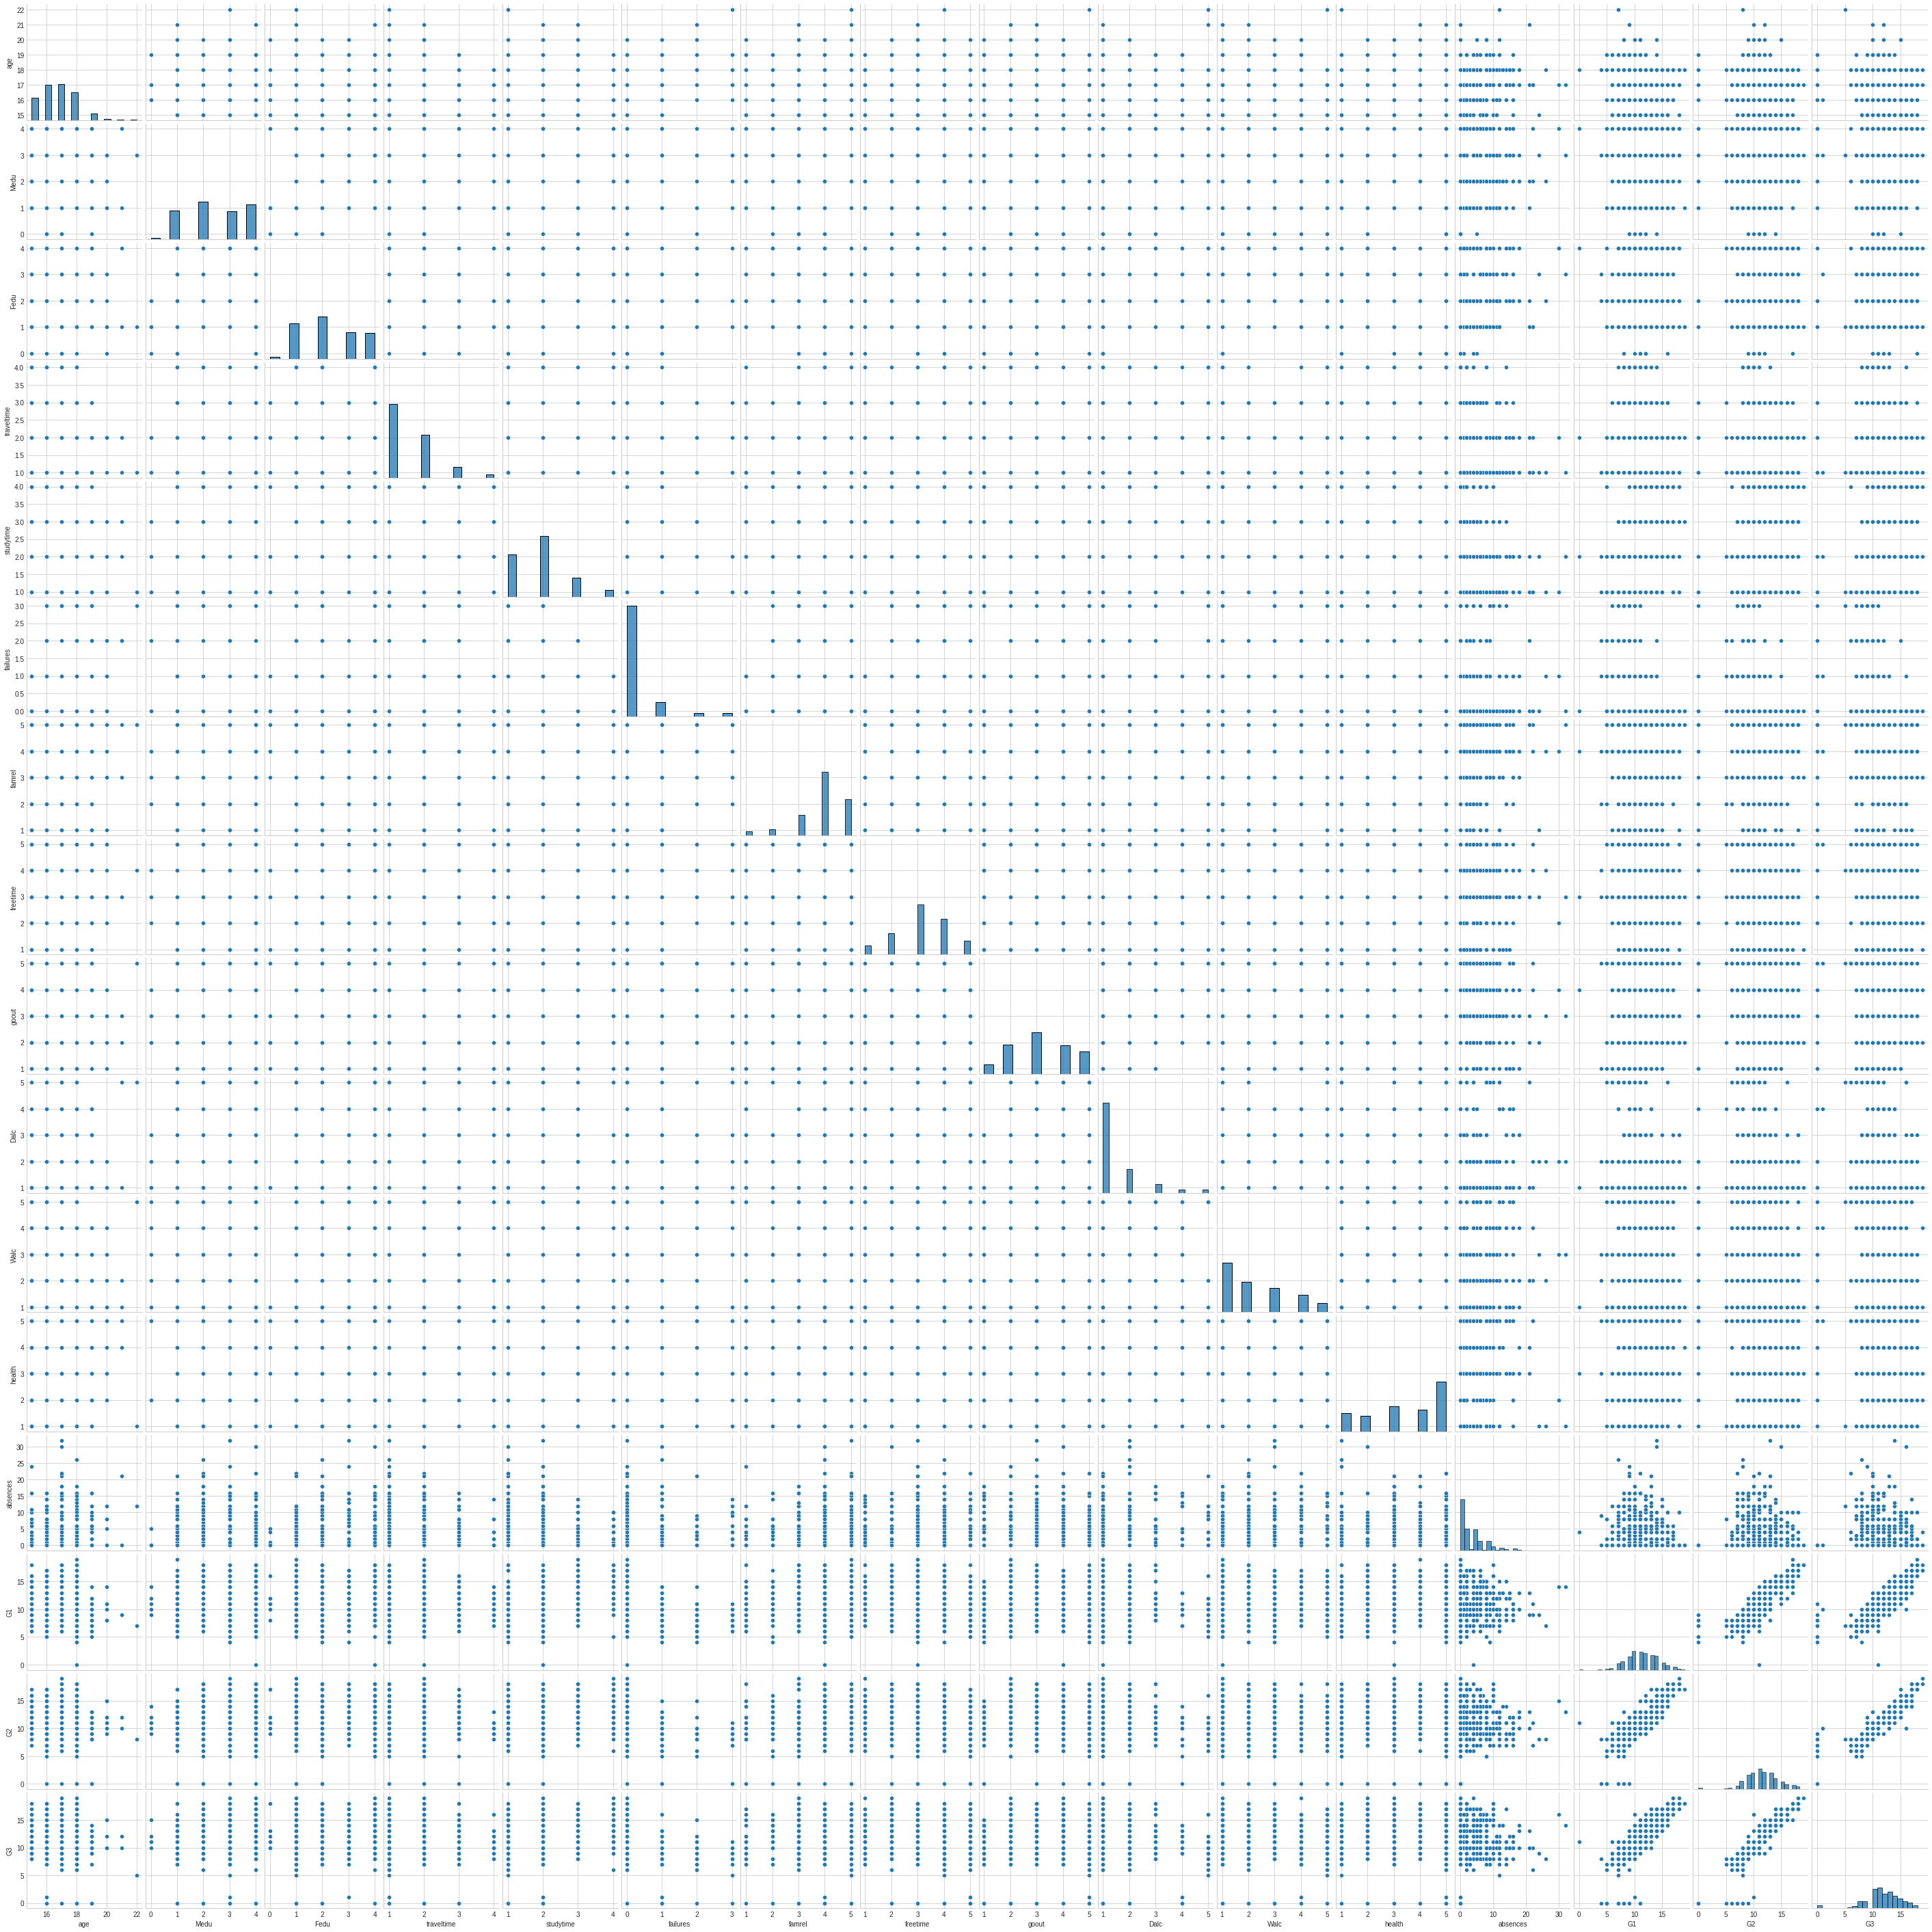

In [11]:
#data plot visualizzare dipendenze tra variabili
sb.pairplot(df)
#salvataggio plot
plt.savefig('pairplor.png')

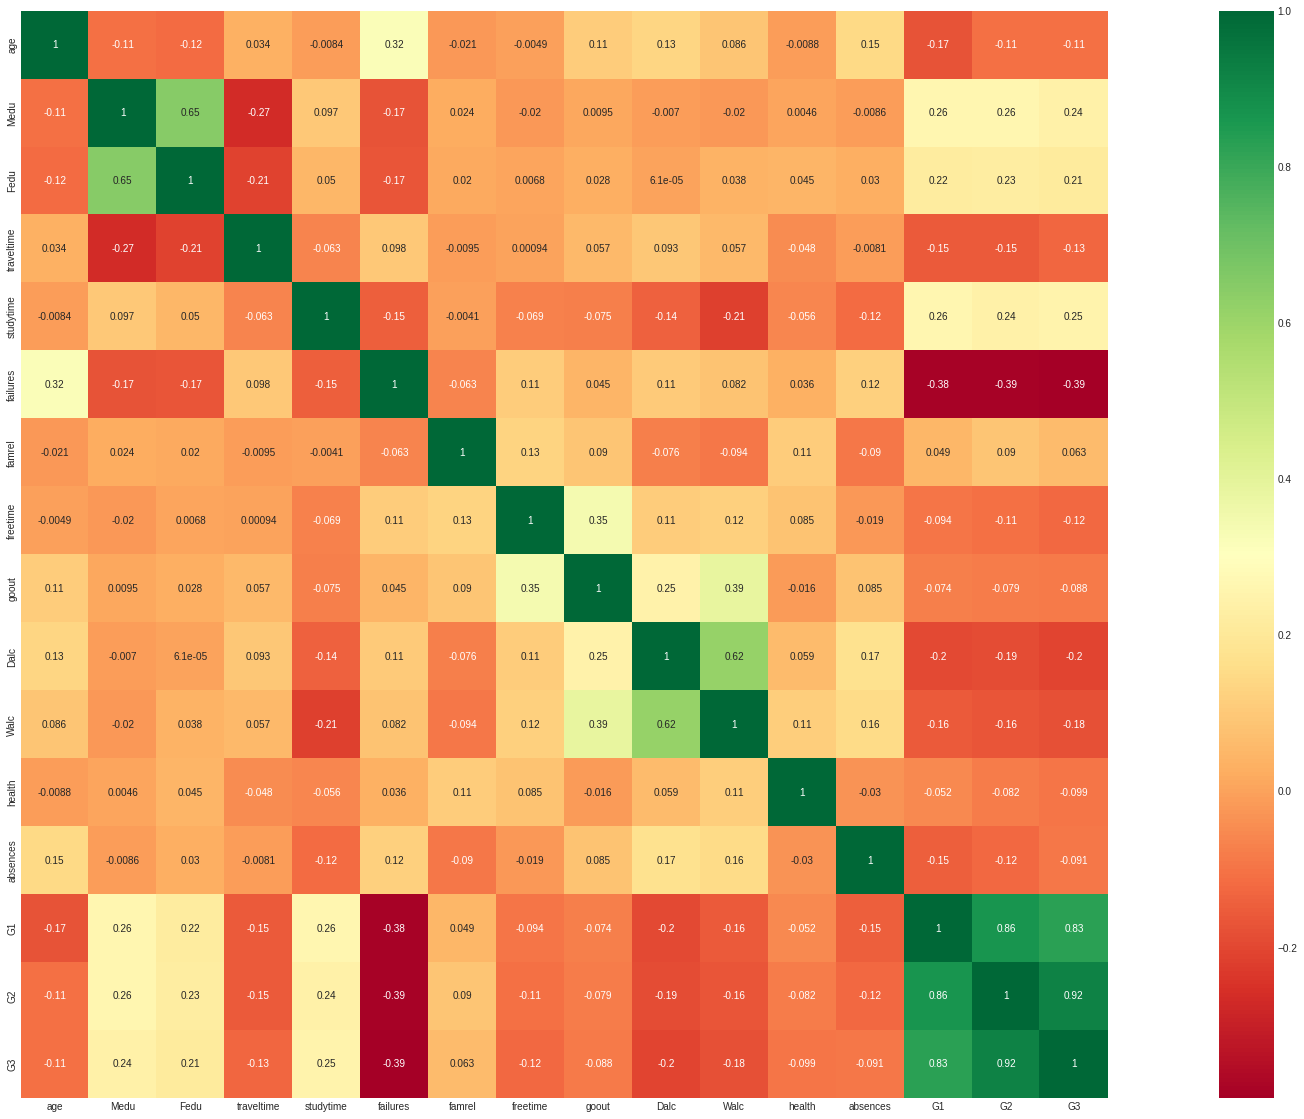

In [12]:
#correlazione tra le variabili
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

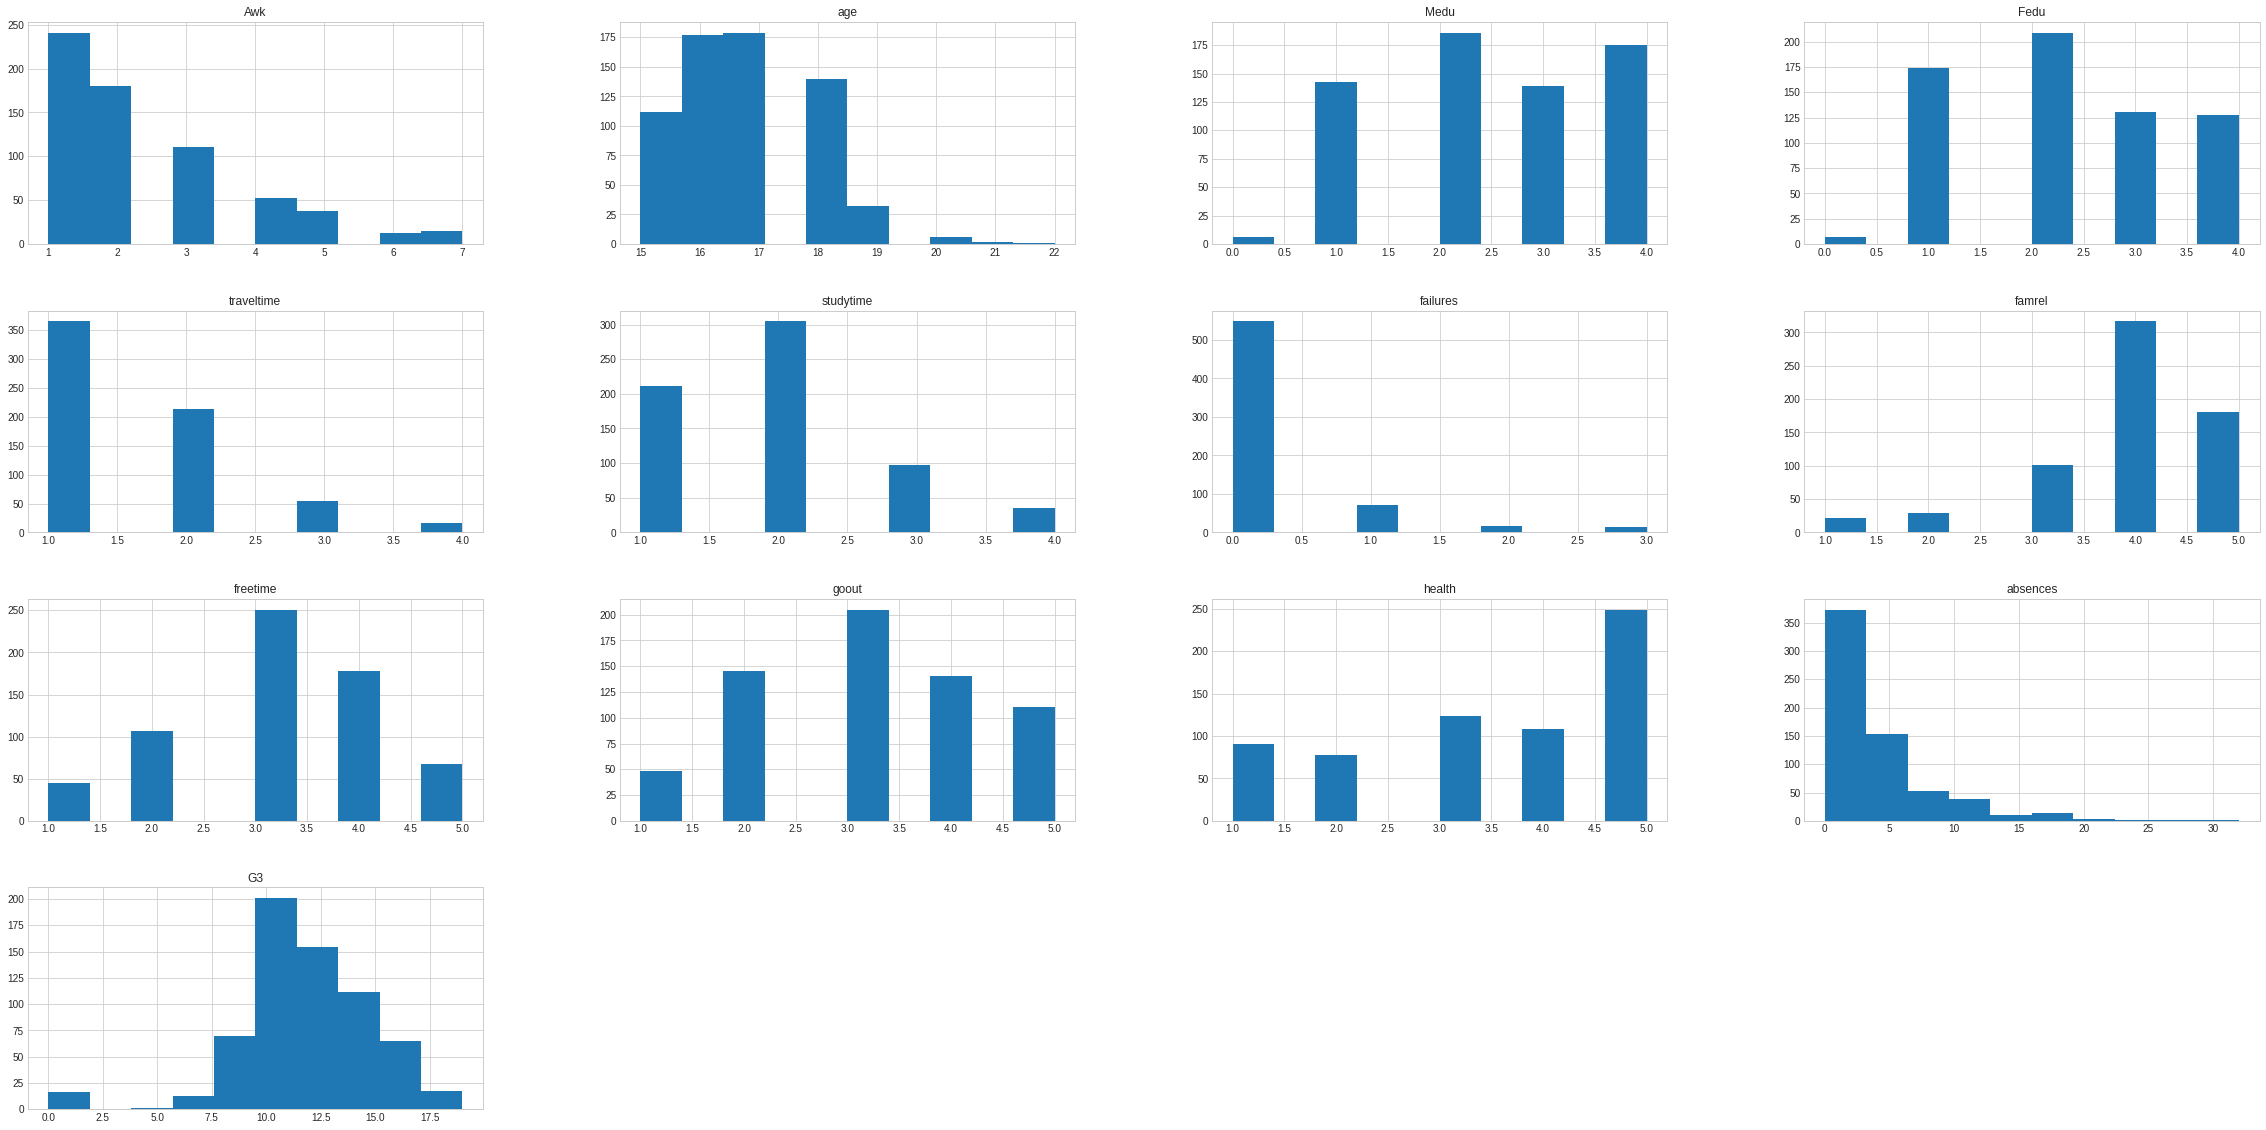

In [13]:
#Eliminazione variabil indipendenti G1,G2 e unione Dalc e Walc in Awk(variabile dipendente)
df=df.drop(columns='G1')
df=df.drop(columns='G2')
dalc=df.Dalc
walk=df.Walc
Awk=dalc+walk//2
df.insert(0,'Awk',Awk)
df=df.drop(columns='Dalc')
df=df.drop(columns='Walc')
#controllo bilanciamento
df.hist()
plt.show()

# **DEFINITION METRICS CLASS**

In [14]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,precision,recall,accuracy,mcc):
    self.precision=precision
    self.recall=recall
    self.accuracy=accuracy
    self.mcc=mcc
  
  #ToString
  def __str__(self):
    return f'Metrics [precision= {self.precision} recall= {self.recall} accuracy= {self.accuracy} mcc= {self.mcc}'

# **DEFINITION METRICSRESULTSCONTAINER CLASS**

In [15]:
import numpy as np
class MetricsResultContainer:
  meanPrecision = []
  meanRecall = []
  meanAccuracy = []
  meanMcc =[]
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean,balance):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanPrecision = []
    self.meanRecall = []
    self.meanAccuracy = []
    self.meanMcc =[]
    self.balance=balance
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanPrecision.append(m.precision)
      self.meanRecall.append(m.recall)
      self.meanAccuracy.append(m.accuracy)
      self.meanMcc.append(m.mcc)
    print("meanPrecision=",np.mean(self.meanPrecision))    
    print("meanRecall=",np.mean(self.meanRecall))    
    print("meanAccuracy=",np.mean(self.meanAccuracy))
    print("meanMcc=",np.mean(self.meanMcc))

# **DIVISIONE TRANING AND TEST, FEATURE SELECTION, FEATURE SCALING AND DEFINITION FUNCTION GENERATE MODEL**

In [16]:
import copy
from sklearn import metrics, clone
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from imblearn.over_sampling import RandomOverSampler

def generateModel(model):
  #array di metriche (precision, recall, accuracy, mcc)
  metrics1 = []
  clone_model = clone(model)
  #training dell'algoritmo sui training set
  clone_model.fit(X_train_z,y_train_over)
  #validazione modello e applicazione predizione sui testSet
  y_pred =clone_model.predict(X_test_z)
  #calcolo metriche predizion
  cm=metrics.confusion_matrix(Y_test,y_pred)
  TP, FP, TN, FN = perf_measure(cm)
  metrics1.append(Metrics1((TP/(TP+FP)),(TP/(TP+FN)),
                            ((TP+TN)/(TP+TN+FP+FN)),
                            metrics.matthews_corrcoef(Y_test,y_pred)))
  return metrics1
   

#divisione dipendente e indipendente
variabileDipendente=df.Awk
#trasformazione dataset stringhe in numeri
lb=LabelEncoder()
variabileIndipendenti=df[['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','health','absences','G3']]
variabileIndipendenti.insert(0,'school',lb.fit_transform(df.school))
variabileIndipendenti.insert(0,'sex',lb.fit_transform(df.sex))
variabileIndipendenti.insert(0,'address',lb.fit_transform(df.address))
variabileIndipendenti.insert(0,'famsize',lb.fit_transform(df.famsize))
variabileIndipendenti.insert(0,'Pstatus',lb.fit_transform(df.Pstatus))
variabileIndipendenti.insert(0,'Mjob',lb.fit_transform(df.Mjob))
variabileIndipendenti.insert(0,'Fjob',lb.fit_transform(df.Fjob))
variabileIndipendenti.insert(0,'reason',lb.fit_transform(df.reason))
variabileIndipendenti.insert(0,'guardian',lb.fit_transform(df.guardian))
variabileIndipendenti.insert(0,'schoolsup',lb.fit_transform(df.schoolsup))
variabileIndipendenti.insert(0,'famsup',lb.fit_transform(df.famsup))
variabileIndipendenti.insert(0,'paid',lb.fit_transform(df.paid))
variabileIndipendenti.insert(0,'activities',lb.fit_transform(df.activities))
variabileIndipendenti.insert(0,'nursery',lb.fit_transform(df.nursery))
variabileIndipendenti.insert(0,'higher',lb.fit_transform(df.higher))
variabileIndipendenti.insert(0,'internet',lb.fit_transform(df.internet))
variabileIndipendenti.insert(0,'romantic',lb.fit_transform(df.romantic))
#divisione training e test
X_train, X_test, Y_train, Y_test=train_test_split(variabileIndipendenti,variabileDipendente,test_size=0.2,random_state=2)
select=SelectKBest(score_func=f_classif,k=10)
scaler=MinMaxScaler()
#Data Balancing
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over= oversample.fit_resample(X_train, Y_train)
#feature scaling sui traing test
X_train_z = scaler.fit_transform(X_train_over)
X_test_z = scaler.transform(X_test)
#applicazione feature selection su train_z
X_train_z = select.fit_transform(X_train_z, y_train_over)
X_test_z = select.transform(X_test_z)
#risultati: array di array di metriche
metricsResults = []
print(X_train_z)

[[1.         0.5        1.         ... 1.         0.         0.47368421]
 [1.         0.5        0.         ... 0.5        0.         0.68421053]
 [0.         0.5        0.         ... 0.25       0.0625     0.52631579]
 ...
 [1.         0.5        0.         ... 0.75       0.25       0.47368421]
 [1.         0.5        0.         ... 0.75       0.25       0.47368421]
 [1.         0.         0.         ... 1.         0.375      0.36842105]]


# **IMPLEMANTION FUNCTION PERFMETRIX**

In [17]:
def perf_measure(confusionMatrix):
  meanTP = []
  meanFP = []
  meanTN = []
  meanFN = []

  #calcolo TP FP TN FN dalla matrice di confusione
  for i in range(len(confusionMatrix)):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for y in range(len(confusionMatrix)): 
      if i==y:
        TP += confusionMatrix[i][y]
      if i!=y:
        FP += confusionMatrix[y][i]
        FN += confusionMatrix[i][y]
    for j in range(len(confusionMatrix)):
      for x in range(len(confusionMatrix)):
        if j!=i and x!= i:
          TN += confusionMatrix[j][x]
    meanTP.append(TP)
    meanFP.append(FP)
    meanTN.append(TN)
    meanFN.append(FN)
  return(np.mean(meanTP), np.mean(meanFP), np.mean(meanTN), np.mean(meanFN))

# **DATA BALANCING**

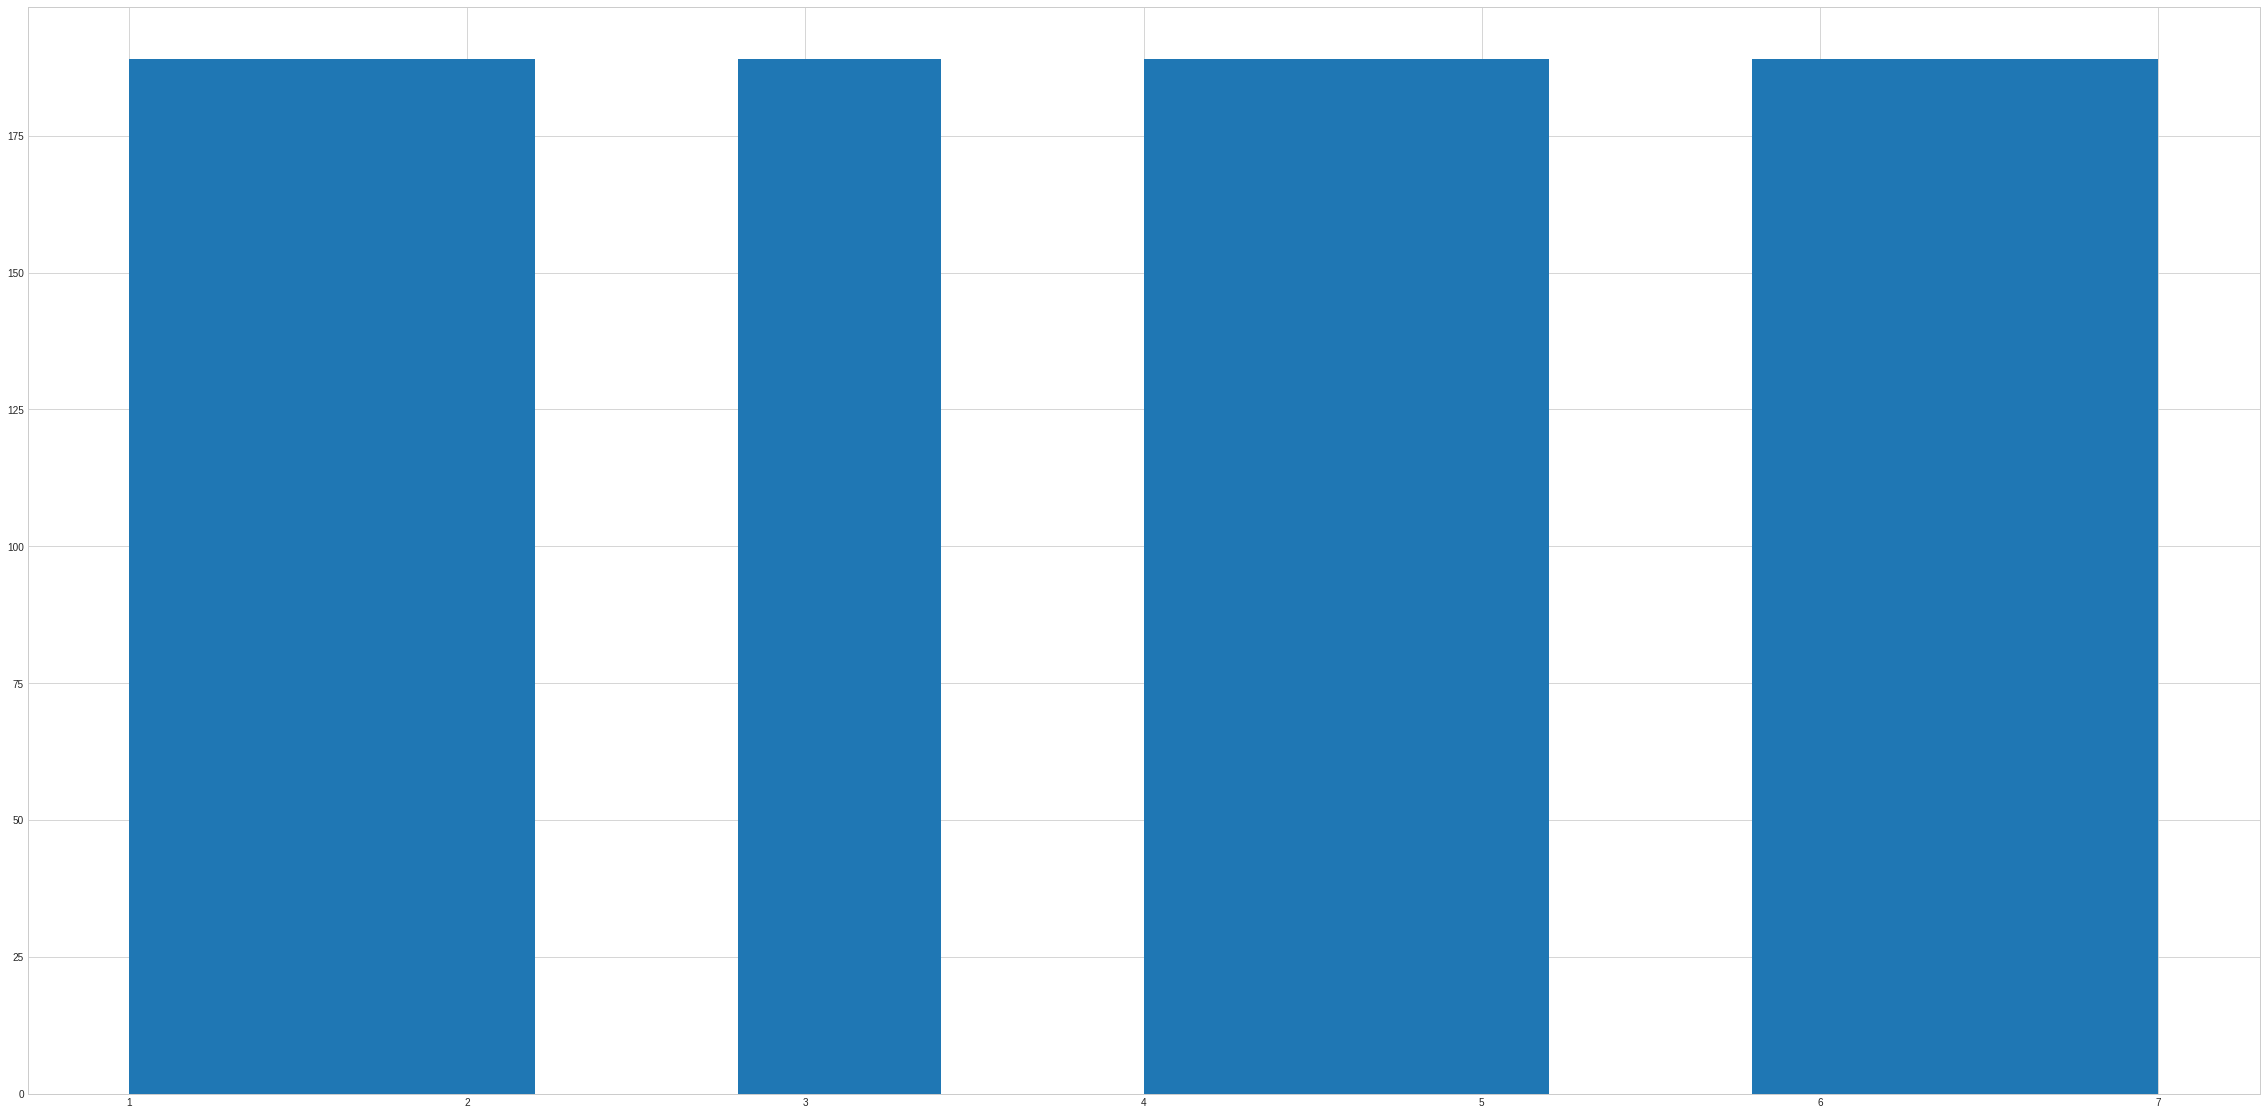

In [18]:
#Stampa Data Balancing
y_train_over.hist()
plt.show()

# **ALGORITIMO EVALUATION OF RANDOM FOREST CLASSIFICATION**

In [19]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

print("Random Forest - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("RandomForest","KF","Minmax","Default",
  generateModel(RandomForestClassifier()),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

Random Forest - MinMax Normalization - KF-OverSampler
meanPrecision= 0.2923076923076924
meanRecall= 0.2923076923076924
meanAccuracy= 0.7978021978021979
meanMcc= 0.03792349203296115


# **ALGORITIMO EVALUATION OF DECISION TREE CLASSIFICATION**

In [20]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

print("DecisionTreeClassifier - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("DecisionTreeClassifier","KF","Minmax","Default",
  generateModel(DecisionTreeClassifier()),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

DecisionTreeClassifier - MinMax Normalization - KF-OverSampler
meanPrecision= 0.2923076923076924
meanRecall= 0.2923076923076924
meanAccuracy= 0.7978021978021979
meanMcc= 0.08225460160291202


# **ALGORITIMO EVALUATION OF  GAUSSIAN NAIVE BAYES CLASSIFICATION**

In [21]:
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB

print("Gaussian Naive Bayes - MinMax Normalization - KF-OverSampler")
#Random Fores K-Fold e MinMax Over sampler
m = MetricsResultContainer("Gaussian Naive Bayes","KF","Minmax","Default",
  generateModel(GaussianNB()),"overSampler"
)
metricsResults.append(m)
m.printMetrics()

Gaussian Naive Bayes - MinMax Normalization - KF-OverSampler
meanPrecision= 0.13076923076923078
meanRecall= 0.13076923076923078
meanAccuracy= 0.7516483516483518
meanMcc= 0.05076527111359722


# **IMPLEMENTATION OF CLASSIFICATION MODEL WITH DECISION TREE**

In [23]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier()
model.fit(X_train_z,y_train_over)
y_pred =model.predict(X_test_z)


# **USE LIME FOR PREDICTION OF MODEL**

In [24]:
! pip install lime

     |████████████████████████████████| 275 kB 23.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=fa6bafc062b0925289567a579a26124e6c6690fc7e39eda73196ebff6f2356b2
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [25]:
import lime
import lime.lime_tabular
import sklearn
import sklearn.ensemble
import numpy as np

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_z, feature_names=select.get_feature_names_out(input_features=X_train_over.columns.values), class_names=[0,1,2,3,4,5,6,7,8,9], categorical_features=[0,1,2,3,4,5,6], 
                                                   verbose=True, mode='classification')
i =25
exp = explainer.explain_instance(X_test_z[i], model.predict_proba, num_features=9)
exp.show_in_notebook(show_table=True)
exp.as_list()

Intercept 0.3084126289719697
Prediction_local [0.19959686]
Right: 0.0


[('sex=1', -0.13484485971640445),
 ('age=0', 0.06593595033001655),
 ('guardian=1', -0.04655418676197623),
 ('goout <= 0.50', -0.033637943720201985),
 ('school=1', 0.031290398794479125),
 ('0.58 < G3 <= 0.68', 0.021052112531154084),
 ('absences <= 0.00', -0.0196179091107331),
 ('famsize=0', 0.011791776794759849),
 ('freetime=0', -0.004231112762879612)]

# **USE SHAP FOR PREDICTION OF MODEL**

In [26]:
! pip install shap

     |████████████████████████████████| 564 kB 16.0 MB/s 


In [27]:
import shap

# predizione
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_z)

#stampa
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1],X_test_z)

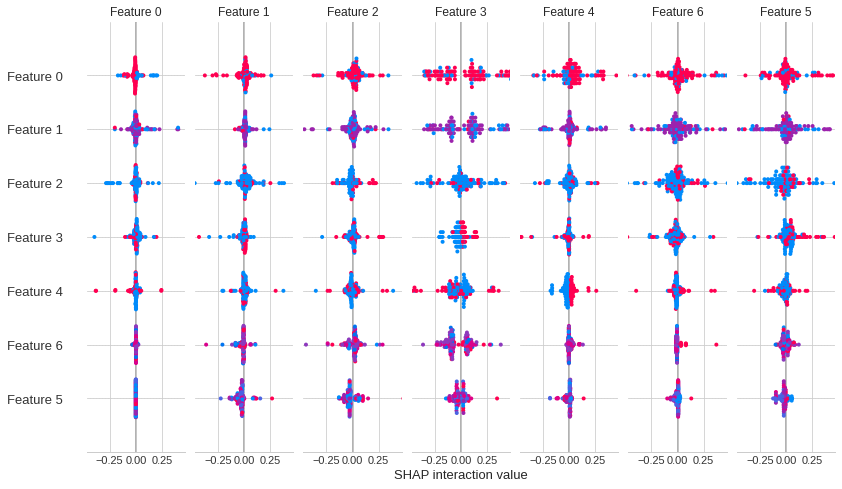

In [28]:
#stampa grafico barre
shap_values = explainer(X_test_z)
shap.summary_plot(shap_values,X_test_z)